In [1]:
filename = "s_unit_attack_output_2025-04-08_14.04.01.csv"

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
import json, pyperclip
import csv
from collections import defaultdict

In [3]:
def load_csv(filename):
    grouped_data = defaultdict(lambda: {
        "n": None,
        "y": None,
        "runs": []
    })

    with open(filename, 'r', newline='') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            # Parse base parameters
            n = int(row["n"])
            y = float(row["y"])
            key = (n, y)

            grouped_data[key]["n"] = n
            grouped_data[key]["y"] = y

            # Clean and convert values
            try:
                run = {
                    "i": int(row["iteration"]),
                    "iterations": int(row["num_inner_iteration"]),
                    "alpha_in": str(row["alpha_in"]),
                    "alpha_in_norm": float(row["alpha_in_norm"]),
                    "alpha_out": str(row["alpha_out"]),
                    "alpha_out_norm": float(row["alpha_out_norm"]),
                    "alpha_in_norm": float(row["alpha_in_norm"]),
                    "alpha_out_norm": float(row["alpha_out_norm"]),
                }
            except Exception as e:
                print(f"Error parsing row: {row}\n{e}")
                continue

            grouped_data[key]["runs"].append(run)

    return list(grouped_data.values())


In [4]:
data = load_csv(filename)

pyperclip.copy(json.dumps(data, indent=2))
print(f"{len(data)} blocks loaded from {filename} and copied to clipboard.")

462 blocks loaded from s_unit_attack_output_2025-04-08_14.04.01.csv and copied to clipboard.


In [5]:
data = load_csv(filename)

pyperclip.copy(json.dumps(data, indent=2))
print(f"{len(data)} blocks loaded from {filename} and copied to clipboard.")

462 blocks loaded from s_unit_attack_output_2025-04-08_14.04.01.csv and copied to clipboard.


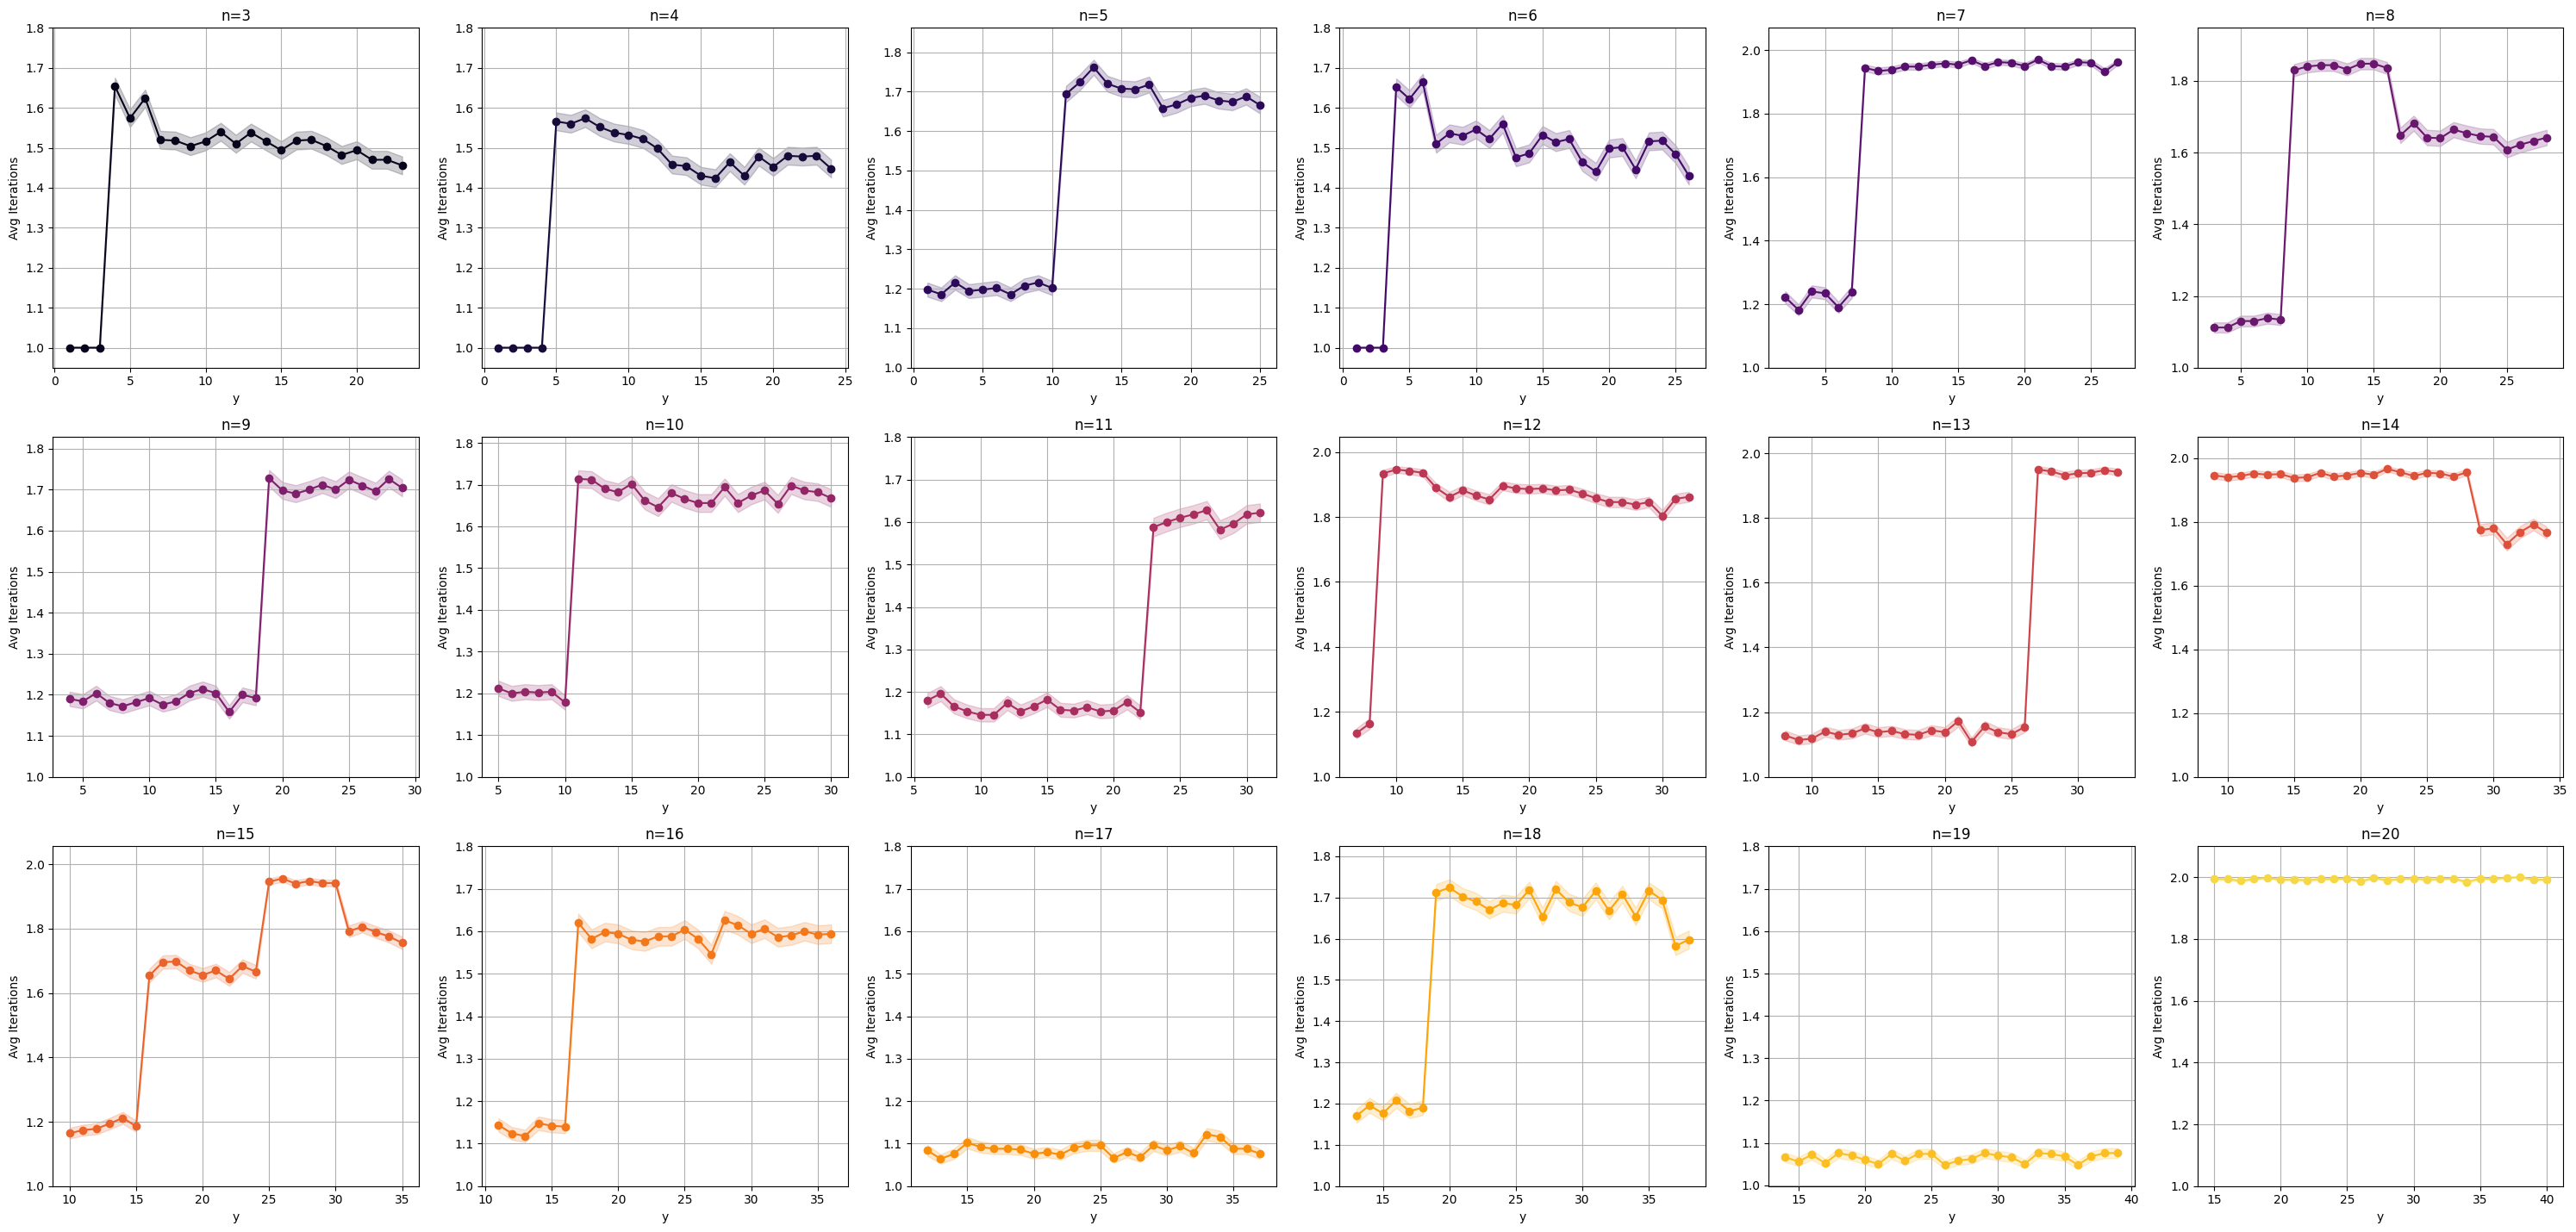

In [6]:
map_n_map_y_vs_iterations = {}
map_n_map_y_vs_stderr = {}

for block in data:
    n = block["n"]
    y = block["y"]

    if n not in map_n_map_y_vs_iterations:
        map_n_map_y_vs_iterations[n] = {}
        map_n_map_y_vs_stderr[n] = {}

    if len(block["runs"]) == 0:
        continue

    iterations = [run["iterations"] for run in block["runs"]]
    avg_iterations = sum(iterations) / len(iterations)
    stderr = np.std(iterations, ddof=1) / np.sqrt(len(iterations))  # standard error

    map_n_map_y_vs_iterations[n][y] = avg_iterations
    map_n_map_y_vs_stderr[n][y] = stderr

num_plots = len(map_n_map_y_vs_iterations)
cols = min(6, num_plots)
rows = (num_plots + cols - 1) // cols

plt.figure(figsize=(5 * cols, 5 * rows))

for i, (n, map_y_vs_iterations) in enumerate(map_n_map_y_vs_iterations.items(), 1):
    plt.subplot(rows, cols, i)
    x = list(map_y_vs_iterations.keys())
    y = list(map_y_vs_iterations.values())
    yerr = [map_n_map_y_vs_stderr[n][val] for val in x]
    c = colormaps['inferno'](i / (num_plots + 2))

    plt.plot(x, y, 'o-', color=c, label=f'n={n}')
    plt.fill_between(x, np.array(y) - np.array(yerr), np.array(y) + np.array(yerr), alpha=0.2, label='Std Error', color=c)
    plt.xlabel('y')

    plt.ylim(min(1, min(y) - 0.05) if min(y) > 0 else min(y), max(1.8, max(y) + 0.1))
    plt.ylabel('Avg Iterations')
    plt.title(f'n={n}')
    plt.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

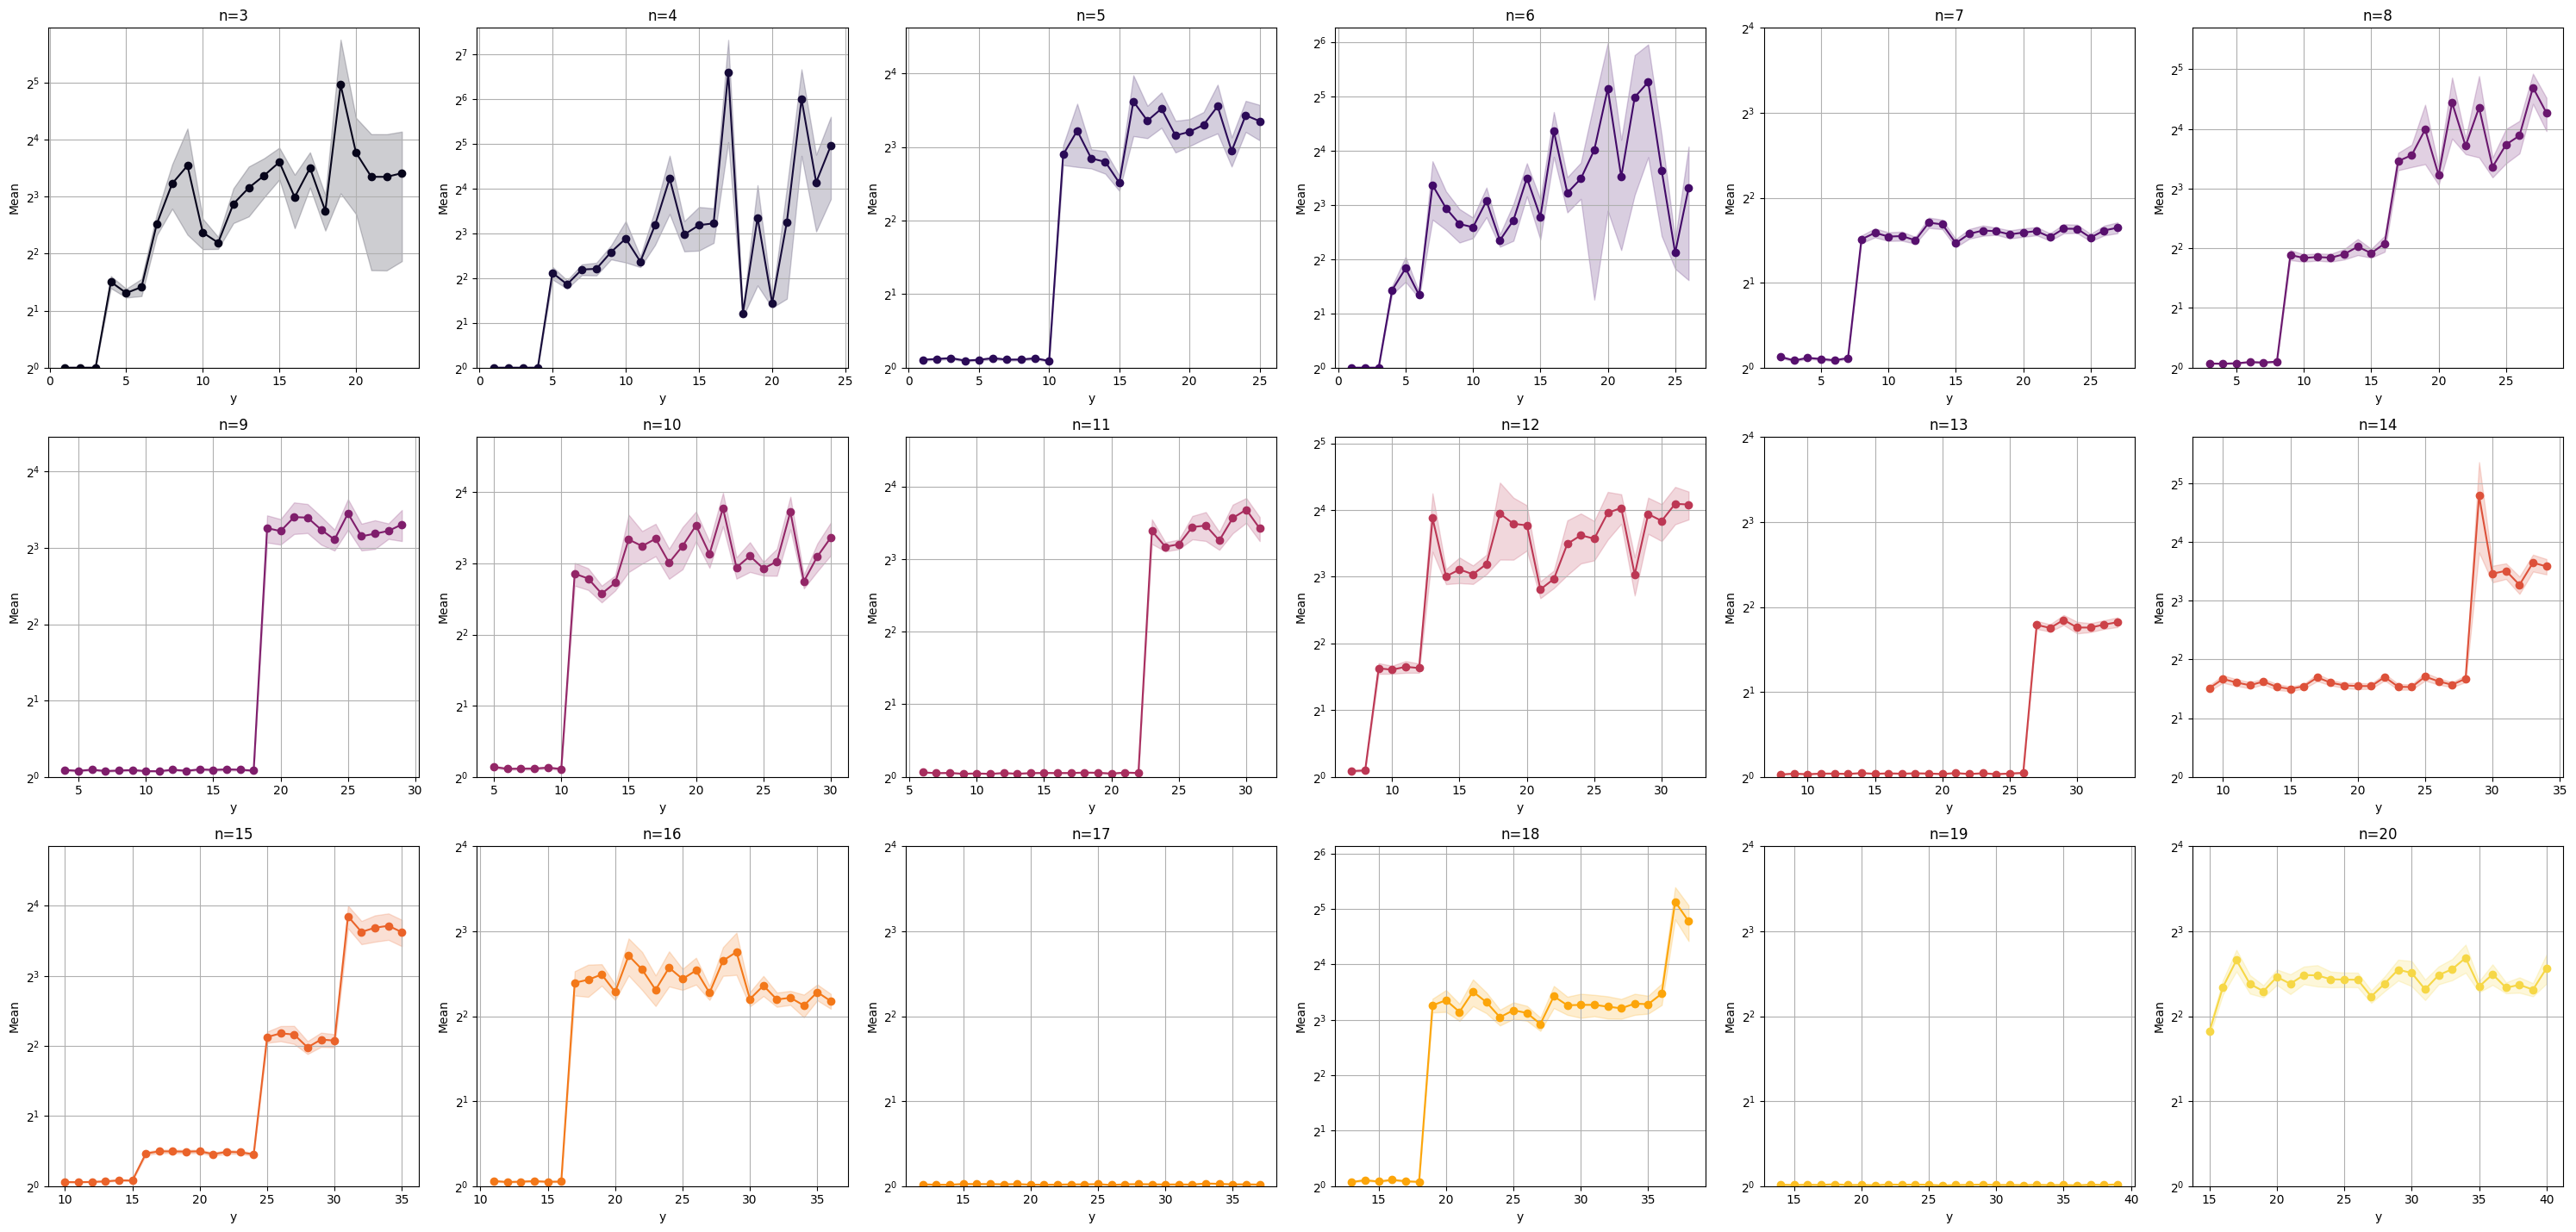

In [7]:
map_n_map_y_vs_iterations = {} 
for block in data:
    n = block["n"]
    y = block["y"]
    
    if n not in map_n_map_y_vs_iterations:
        map_n_map_y_vs_iterations[n] = {}
    
    if len(block["runs"]) == 0:
        continue
    
    norm_reductions = []
    for run in block["runs"]:
        if run["alpha_in_norm"] > 20_000: continue # skip runs with too high alpha_in_norm
        if run["alpha_out_norm"] == 0: run["alpha_out_norm"] = 1
        val = run["alpha_in_norm"] / run["alpha_out_norm"]
        norm_reductions.append(np.abs(val))
    map_n_map_y_vs_iterations[n][y] = norm_reductions 

num_plots = len(map_n_map_y_vs_iterations)
cols = min(6, num_plots)
rows = (num_plots + cols - 1) // cols

plt.figure(figsize=(5 * cols, 5 * rows))

for i, (n, map_y_vs_iterations) in enumerate(map_n_map_y_vs_iterations.items(), 1):
    ax1 = plt.subplot(rows, cols, i)
    
    x = list(map_y_vs_iterations.keys())
    y_vals = list(map_y_vs_iterations.values())
    y_mean = [np.mean(reductions) for reductions in y_vals]
    yerr = [np.std(reductions) / np.sqrt(len(reductions)) if len(reductions) > 0 else 0 for reductions in y_vals]
    c = colormaps['inferno'](i / (num_plots + 2))
    
    ax1.set_yscale('log', base=2)
    ax1.plot(x, y_mean, 'o-', label='Mean', color=c)
    ax1.fill_between(x, np.array(y_mean) - np.array(yerr), np.array(y_mean) + np.array(yerr), alpha=0.2, label='Std Error', color=c)
    plt.title(f'n={n}')
    plt.grid(True)
    plt.ylim(1, top=max(2**4, max(y_mean) * 2)) # Easy to spot trends
    
    ax1.set_xlabel('y')
    ax1.set_ylabel('Mean')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()